In [17]:
import boto3
from sagemaker import get_execution_role

sm_client = boto3.client(service_name='sagemaker')
runtime_sm_client = boto3.client(service_name='sagemaker-runtime')

account_id = boto3.client('sts').get_caller_identity()['Account']
region = boto3.Session().region_name

#used to store model artifacts which SageMaker will extract to /opt/ml/model in the container, 
#in this example case we will not be making use of S3 to store the model artifacts
#s3_bucket = '<S3Bucket>'

role = get_execution_role()
role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


'arn:aws:iam::584910123950:role/AmazonSageMaker-ExecutionRole'

In [3]:
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 93.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 80.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
from prophet import Prophet

# Python
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [5]:
m = Prophet()
m.fit(df)

15:34:26 - cmdstanpy - INFO - Chain [1] start processing
15:34:27 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


In [7]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.205353,7.440230,8.959891
3266,2017-01-16,8.530344,7.803481,9.234224
3267,2017-01-17,8.317743,7.583560,9.062811
3268,2017-01-18,8.150364,7.410168,8.909814
3269,2017-01-19,8.162259,7.417846,8.904108


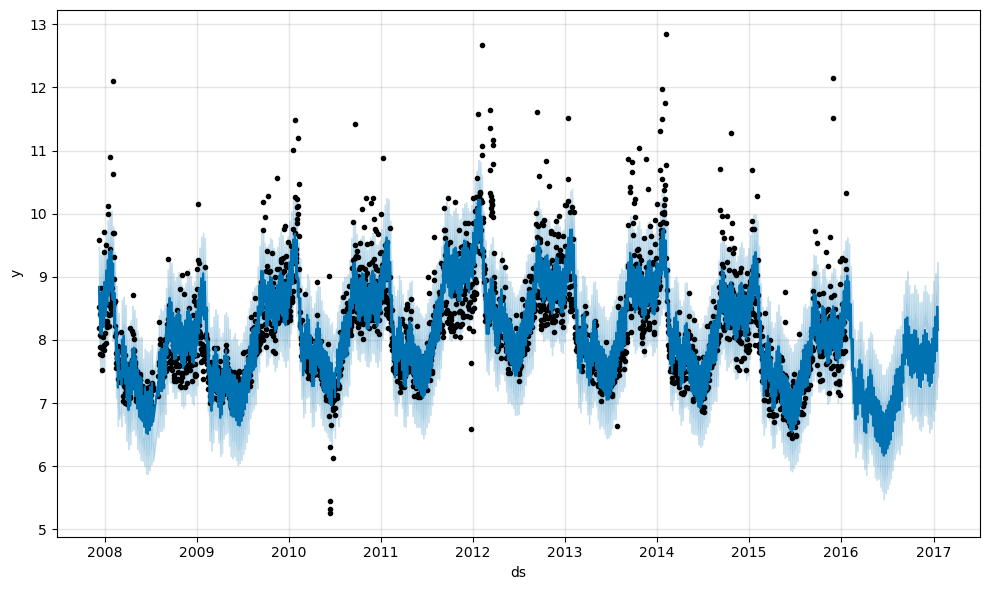

In [8]:
fig1 = m.plot(forecast)


In [13]:
import joblib
import os
# Create a directory to save the model
if not os.path.exists('model'):
    os.makedirs('model')

# Save model as a pkl file
model_path = 'model/prophet_model.pkl'
joblib.dump(m, model_path)


['model/prophet_model.pkl']

In [14]:
import tarfile

# Compress the model into .tar.gz
with tarfile.open('prophet_model.tar.gz', 'w:gz') as tar:
    tar.add('model/', arcname=os.path.basename('model'))


In [15]:
import boto3

s3 = boto3.client('s3')
bucket_name = 'dse-oats-llm-medhat-elhady'
model_file = 'prophet_model.tar.gz'

# Upload the model to S3
s3.upload_file(model_file, bucket_name, model_file)


In [18]:
from time import gmtime, strftime

model_name = 'profit-model-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
# MODEL S3 URL containing model atrifacts as either model.tar.gz or extracted artifacts. 
# Here we are not  
#model_url = 's3://{}/spacy/'.format(s3_bucket) 
# 584910123950.dkr.ecr.us-east-1.amazonaws.com/sagemaker-jobs:profit-inference
container = '{}.dkr.ecr.{}.amazonaws.com/sagemaker-jobs:profit-inference'.format(account_id, region) 
instance_type = 'ml.m5.24xlarge'

print('Model name: ' + model_name)
#print('Model data Url: ' + model_url)
print('Container image: ' + container)

container = {
    'Image': container,
    'ModelDataUrl': 's3://dse-oats-llm-medhat-elhady/prophet_model.tar.gz'
}

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    Containers = [container])

print("Model Arn: " + create_model_response['ModelArn'])

Model name: profit-model-2024-10-13-15-41-26
Container image: 584910123950.dkr.ecr.us-east-1.amazonaws.com/sagemaker-jobs:profit-inference
Model Arn: arn:aws:sagemaker:us-east-1:584910123950:model/profit-model-2024-10-13-15-41-26


In [19]:
endpoint_config_name = 'prophet-config' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print('Endpoint config name: ' + endpoint_config_name)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType': instance_type,
        'InitialInstanceCount': 1,
        'InitialVariantWeight': 1,
        'ModelName': model_name,
        'VariantName': 'AllTraffic'}])
        
print("Endpoint config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

Endpoint config name: prophet-config2024-10-13-15-41-41
Endpoint config Arn: arn:aws:sagemaker:us-east-1:584910123950:endpoint-config/prophet-config2024-10-13-15-41-41


In [20]:
%%time

import time

#endpoint_name = 'flan-t5-endpoint' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
endpoint_name = 'prophet-endpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print('Endpoint name: ' + endpoint_name)

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print('Endpoint Arn: ' + create_endpoint_response['EndpointArn'])

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Endpoint Status: " + status)

print('Waiting for {} endpoint to be in service...'.format(endpoint_name))
waiter = sm_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)


Endpoint name: prophet-endpoint2024-10-13-15-41-53
Endpoint Arn: arn:aws:sagemaker:us-east-1:584910123950:endpoint/prophet-endpoint2024-10-13-15-41-53
Endpoint Status: Creating
Waiting for prophet-endpoint2024-10-13-15-41-53 endpoint to be in service...


WaiterError: Waiter EndpointInService failed: Waiter encountered a terminal failure state: For expression "EndpointStatus" we matched expected path: "Failed"

In [34]:
import json
content_type = "application/json"
request_body = {"input": ['2017-01-15']}

#Serialize data for endpoint
#data = json.loads(json.dumps(request_body))
payload = json.dumps(request_body)

#Endpoint invocation
response = runtime_sm_client.invoke_endpoint(
EndpointName=endpoint_name,
ContentType=content_type,
Body=payload)

#Parse results
result = json.loads(response['Body'].read().decode())['output']
result

[['NER', 'ORG'],
 ['America', 'GPE'],
 ['Amazon', 'ORG'],
 ['Microsoft', 'ORG'],
 ['Seattle', 'GPE']]

In [6]:
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_model(ModelName=model_name)

{'ResponseMetadata': {'RequestId': '679db93e-751c-4d23-9509-dc451dcda962',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '679db93e-751c-4d23-9509-dc451dcda962',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 09 Sep 2024 17:19:29 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}